In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download necessary resources for nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv("/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [5]:
data.shape

(17880, 18)

In [6]:
len(data['department'].unique())

1338

In [7]:
len(data['industry'].unique())

132

In [8]:
# Group by 'industry' and get the size of each group
industry_counts = data.groupby('industry').size().reset_index(name='count')


In [9]:
industry_counts = industry_counts.sort_values(by='count', ascending=False)
top_20_industry_counts= industry_counts.iloc[:int(0.20*len(industry_counts))]

In [10]:
top_20_industry_counts.head(5)

,industry,count
58,Information Technology and Services,1734
22,Computer Software,1376
61,Internet,1062
75,Marketing and Advertising,828
31,Education Management,822


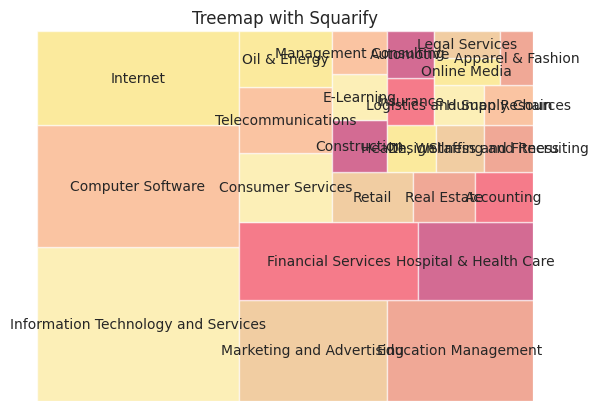

In [11]:
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette

sns.set_style(style="whitegrid") # set seaborn plot style
sizes= top_20_industry_counts['count']# proportions of the categories
label= top_20_industry_counts['industry']
squarify.plot(sizes=sizes, label=label, alpha=0.6, color=colors).set(title='Treemap with Squarify')

plt.axis('off')
plt.show()

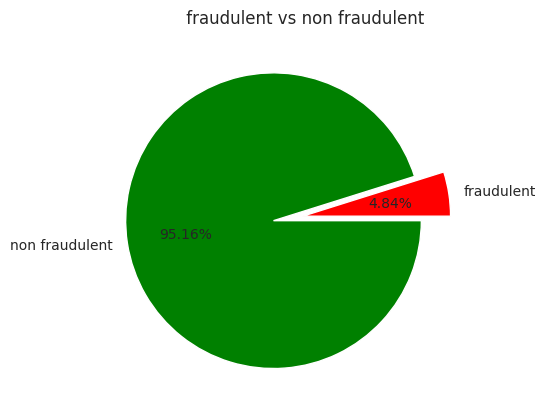

In [12]:
data_fraud = data[data['fraudulent'] == 1]  #fraudulent
data_non_fraud = data[data['fraudulent'] == 0]  # non fraudulent

plt.title(' fraudulent vs non fraudulent')
plt.pie([data_fraud.shape[0], data_non_fraud.shape[0]], 
        labels=['fraudulent', 'non fraudulent'], 
        explode=(0, 0.2),
        autopct='%1.2f%%',
       colors=['red','green'])
plt.show()

In [13]:
data1 = data.drop(['salary_range', 'job_id'], axis=1)

In [14]:
data1.isnull().sum()

title                      0
location                 346
department             11547
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [15]:
data1 = data1.fillna({'employment_type': 'unknown', 'required_experience': 'unknown', 'required_education' : 'unknown' })

In [16]:
text_col = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'function'  ]


In [17]:
data2 = data1.fillna(" ")

In [18]:
data2.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [19]:
data2['combined_description'] = data2['title'] + " " + data2['location'] + " " + data2['department']+ " " + data2['company_profile'] + " " + data2['description'] + " " + data2['requirements'] + " " + data2['benefits']+ " " + data2[ 'industry'] + " " + data2['function']                    

In [20]:
data2.head(1)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,combined_description
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,unknown,,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."


In [21]:
data3 = data2.drop(text_col, axis=1)

In [22]:
data3.head(4)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,combined_description
0,0,1,0,Other,Internship,unknown,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,Full-time,Not Applicable,unknown,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,unknown,unknown,unknown,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0,"Account Executive - Washington DC US, DC, Wash..."


In [23]:
data3.groupby('fraudulent').size()

fraudulent
0    17014
1      866
dtype: int64

In [24]:
data4 = pd.get_dummies(data3, columns = ['employment_type','required_experience','required_education']) 


In [25]:
data4.head(4)

,telecommuting,has_company_logo,has_questions,fraudulent,combined_description,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,...,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Vocational,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_unknown
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We...",False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ...",False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA...",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash...",False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 33 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   telecommuting                                         17880 non-null  int64 
 1   has_company_logo                                      17880 non-null  int64 
 2   has_questions                                         17880 non-null  int64 
 3   fraudulent                                            17880 non-null  int64 
 4   combined_description                                  17880 non-null  object
 5   employment_type_Contract                              17880 non-null  bool  
 6   employment_type_Full-time                             17880 non-null  bool  
 7   employment_type_Other                                 17880 non-null  bool  
 8   employment_type_Part-time                             17880 non-nu

In [27]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [28]:
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [29]:
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    
#     wordnet_lemmatizer = WordNetLemmatizer()
    # Tokenize the text
    

    
    tokens = word_tokenize(text)
    
    # Remove stop words and lemmatize the tokens
    filtered_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    
    # Join the tokens back into a single string
    return " ".join(filtered_tokens) 


In [30]:
data4['processed_text'] = data4['combined_description'].apply(preprocess_text)

In [31]:
data4.head(1)

,telecommuting,has_company_logo,has_questions,fraudulent,combined_description,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,...,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Vocational,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_unknown,processed_text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We...",False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,Marketing Intern US NY New York Marketing 're ...


In [32]:
data4 = data4.drop(['combined_description'], axis=1)

In [33]:
train_X , test_X ,train_Y , test_Y = train_test_split(data4['processed_text'],data4['fraudulent'] , test_size = 0.2 , random_state = 0)

In [34]:
cv=TfidfVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train = cv.fit_transform(train_X)
cv_test = cv.transform(test_X)

In [35]:
train_X.shape

(14304,)

In [36]:
cv_train.shape

(14304, 1667216)

In [37]:
cv_test.shape

(3576, 1667216)

In [38]:
cv_train

<14304x1667216 sparse matrix of type '<class 'numpy.float64'>'
	with 1667216 stored elements in Compressed Sparse Row format>

In [39]:
clf = LogisticRegression(random_state=0).fit(cv_train, train_Y)

In [40]:
predict_test = clf.predict(cv_test)

In [41]:
predict_train = clf.predict(cv_train)

In [42]:
accuracy_score(test_Y, predict_test)

0.9572147651006712

In [43]:
accuracy_score(train_Y, predict_train)

0.950153803131991

In [44]:
confusion_matrix(test_Y, predict_test)

array([[3423,    0],
       [ 153,    0]])

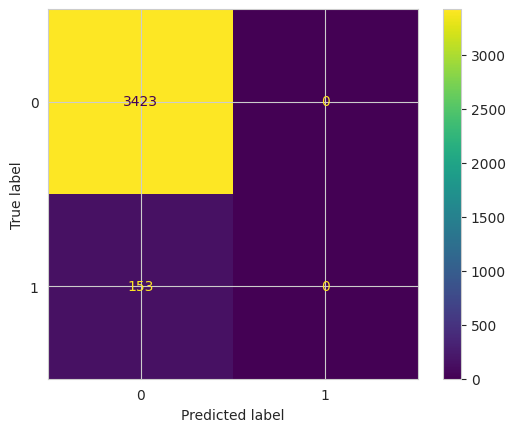

In [45]:
cm = confusion_matrix(test_Y, predict_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()